# Install packages and import libraries

In [ ]:
#  !pip install earthengine-api --upgrade

### Install packages
!pip install pandas
!pip install geemap

### Import libraries
import ee
import folium
# import geemap
#import geemap.foliumap as geemap
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
from datetime import datetime, timedelta # needed for datetime.strptime
from google.colab import files

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 15.0 MB/s eta 0:00:00


In [ ]:
# To access DAHITI from API
import requests
import json
import pprint

In [ ]:
# Mount to Google Drive
from google.colab import drive
drive.mount('/drive') # /content/drive

Mounted at /drive


In [ ]:
# Trigger the authentication flow.
ee.Authenticate('')
ee.Initialize(project='ee-reachsyriagee')

# Functions

In [ ]:
# Define a method for displaying Earth Engine image tiles to folium map.
def add_ee_layer(self, ee_image_object, vis_params, name):
  map_id_dict = ee.Image(ee_image_object).getMapId(vis_params)
  folium.raster_layers.TileLayer(
    tiles = map_id_dict['tile_fetcher'].url_format,
    attr = 'Map Data &copy; <a href="https://earthengine.google.com/">Google Earth Engine</a>',
    name = name,
    overlay = False, # Set back to True if wanting to have tick off boxes for selecting layers
    control = True
  ).add_to(self)


def get_s2_sr_cld_col(aoi, start_date, end_date):
    # Import and filter s2cloudless.
    s2_cloudless_col = (ee.ImageCollection('COPERNICUS/S2_CLOUD_PROBABILITY')
        .filterBounds(aoi)
        .filterDate(start_date, end_date))

    # Join the filtered s2cloudless collection to the SR collection by the 'system:index' property.
    return ee.ImageCollection(ee.Join.saveFirst('s2cloudless').apply(**{
        'primary': s2_sr_col,
        'secondary': s2_cloudless_col,
        'condition': ee.Filter.equals(**{
            'leftField': 'system:index',
            'rightField': 'system:index'
        })
    }))

def add_cloud_bands(img):
    # Get s2cloudless image, subset the probability band.
    cld_prb = ee.Image(img.get('s2cloudless')).select('probability')

    # Condition s2cloudless by the probability threshold value.
    is_cloud = cld_prb.gt(CLD_PRB_THRESH).rename('clouds')

    # Add the cloud probability layer and cloud mask as image bands.
    return img.addBands(ee.Image([cld_prb, is_cloud]))

def add_shadow_bands(img):
    # Identify water pixels from the SCL band.
    not_water = img.select('SCL').neq(6)

    # Identify dark NIR pixels that are not water (potential cloud shadow pixels).
    SR_BAND_SCALE = 1e4
    dark_pixels = img.select('B8').lt(NIR_DRK_THRESH*SR_BAND_SCALE).multiply(not_water).rename('dark_pixels')

    # Determine the direction to project cloud shadow from clouds (assumes UTM projection).
    shadow_azimuth = ee.Number(90).subtract(ee.Number(img.get('MEAN_SOLAR_AZIMUTH_ANGLE')));

    # Project shadows from clouds for the distance specified by the CLD_PRJ_DIST input.
    cld_proj = (img.select('clouds').directionalDistanceTransform(shadow_azimuth, CLD_PRJ_DIST*10)
        .reproject(**{'crs': img.select(0).projection(), 'scale': 100})
        .select('distance')
        .mask()
        .rename('cloud_transform'))

    # Identify the intersection of dark pixels with cloud shadow projection.
    shadows = cld_proj.multiply(dark_pixels).rename('shadows')

    # Add dark pixels, cloud projection, and identified shadows as image bands.
    return img.addBands(ee.Image([dark_pixels, cld_proj, shadows]))

def add_cld_shdw_mask(img):
    # Add cloud component bands.
    img_cloud = add_cloud_bands(img)

    # Add cloud shadow component bands.
    img_cloud_shadow = add_shadow_bands(img_cloud)

    # Combine cloud and shadow mask, set cloud and shadow as value 1, else 0.
    is_cld_shdw = img_cloud_shadow.select('clouds').add(img_cloud_shadow.select('shadows')).gt(0)

    # Remove small cloud-shadow patches and dilate remaining pixels by BUFFER input.
    # 20 m scale is for speed, and assumes clouds don't require 10 m precision.
    is_cld_shdw = (is_cld_shdw.focal_min(2).focal_max(BUFFER*2/20)
        .reproject(**{'crs': img.select([0]).projection(), 'scale': 20})
        .rename('cloudmask'))

    # Add the final cloud-shadow mask to the image.
    return img_cloud_shadow.addBands(is_cld_shdw)

def apply_cld_shdw_mask(img):
    # Subset the cloudmask band and invert it so clouds/shadow are 0, else 1.
    not_cld_shdw = img.select('cloudmask').Not()

    # Subset reflectance bands and update their masks, return the result.
    return img.select(['QA60', 'B1','B2','B3','B4','B5','B6','B7','B8','B8A', 'B9', 'B11','B12'])\
              .updateMask(not_cld_shdw);




def add_cloud_percentage(img):

  cloudmask = img.select('cloudmask')
  cloud_area = cloudmask.eq(1).multiply(ee.Image.pixelArea()).rename('cloud_area')#.divide(1000000)
  total_area = cloudmask.eq(1).Or(cloudmask.eq(0)).multiply(ee.Image.pixelArea()).rename('total_area')#.divide(1000000)

  area = cloud_area.addBands(total_area).reduceRegion(
    geometry = aoi,\
    reducer = ee.Reducer.sum(),\
    scale = 10,\
    maxPixels = 20000000000,\
    tileScale = 16
  )

  perc = ee.Number(area.get('cloud_area')).divide(ee.Number(area.get('total_area')))

  return img.set('cloud_perc', perc)


def add_water_extent (img):
  # calculate water extent based on MNDWI and NDWI thresholds
  water_MNDWI = img.select('MNDWI').gte(0).rename('water_MNDWI')
  water_NDWI = img.select('NDWI').lte(0).rename('water_NDWI')
  water = water_MNDWI.Or(water_NDWI).rename('water')

  water_area = water.multiply(ee.Image.pixelArea()).divide(1000000)

  water_extent = water_area.reduceRegion(\
    geometry = aoi,\
    reducer= ee.Reducer.sum(),\
    scale= 10,\
    maxPixels= 20000000000,\
    tileScale= 16\
  ).get('water')

  return img.addBands(water_MNDWI).addBands(water_NDWI).addBands(water)\
                .set('water_extent', water_extent)\
                .set('date', ee.Image(img).date().format('YYYY-MM-dd'))

class color:
   PURPLE = '\033[95m'
   CYAN = '\033[96m'
   DARKCYAN = '\033[36m'
   BLUE = '\033[94m'
   GREEN = '\033[92m'
   YELLOW = '\033[93m'
   RED = '\033[91m'
   BOLD = '\033[1m'
   UNDERLINE = '\033[4m'
   END = '\033[0m'

def convert_imgCol_to_clientDict(imgCol, propNames_list):
  n = len(propNames_list)
  propVals = imgCol.reduceColumns(reducer = ee.Reducer.toList().repeat(n), selectors = propNames_list).get('list');
  dict_EE = ee.Dictionary.fromLists(propNames_list, propVals);
  clientDict = dict_EE.getInfo();

  return clientDict

# ❗(1) SELECT PARAMETERS


**1. Select dam.**

*   'Tabqa'
*   'Tishreen'


In [ ]:
AOI_name = 'Tabqa'

**2. Select date of most recent csv in Google Drive.** (Check the files in Google Drive:  `/content/drive/My Drive/Water_level_estimates/[AOI_name]`



In [ ]:
date_last_csv = '2023-10-29' # format: YYYY-MM-dd

## AOI parameters

### Fetch current csv

Fetch current csv from Google Drive for the AOI.

In [ ]:
file_name = 'Water_level_' + AOI_name + '_' + date_last_csv
df = pd.read_csv('/drive/My Drive/Water_level_estimates/' + AOI_name +'/'+file_name+'.csv') # CHANGE AGAIN!
last_date_csv = df[['Date', 'Water level [m] (pred.)']].dropna().iloc[-1]['Date']
print('Most recent date in csv: ', last_date_csv)

Most recent date in csv:  2023-10-29


In [ ]:
print(file_name)

Water_level_Tabqa_2023-10-29


### Points and Polgyons for the reservoirs

In [ ]:
dam_Tishrin = ee.Geometry.Point([38.17848300813228, 36.380737152690656])
dam_Tabqa = ee.Geometry.Point([38.56510446209167, 35.870972690621606])

AOI_Tishrin = ee.Geometry.Polygon([[[38.010548494142455, 36.77219104042317],\
          [38.01569839600435, 36.74110824284246],\
          [38.026176043583746, 36.73367716123688],\
          [38.036649936886825, 36.713587869904266],\
          [38.05072899823461, 36.69652043842134],\
          [38.05930093279661, 36.6568744618735],\
          [38.12523045780217, 36.655512147126174],\
          [38.192511492994484, 36.629602547847256],\
          [38.21019180731715, 36.62946544648836],\
          [38.220320960050884, 36.64034714332425],\
          [38.21843376953154, 36.658387455299525],\
          [38.21036454323464, 36.67477505064971],\
          [38.172598576085775, 36.680832692000756],\
          [38.11903965180163, 36.68964304884765],\
          [38.099815185832384, 36.68936793032813],\
          [38.09552421465149, 36.70010393247643],\
          [38.090886883719875, 36.722672753019154],\
          [38.08814355046176, 36.73340056056873],\
          [38.07724271024235, 36.74990858376371],\
          [38.074407177125046, 36.75761400853883],\
          [38.0593008500423, 36.77659110765869]]]);


AOI_Assad = ee.Geometry.Polygon(\
        [[[38.195303453856226, 36.3722378548376],\
          [38.16852427905154, 36.3755550285924],\
          [38.159597887449976, 36.34569537289177],\
          [38.15753795092654, 36.31969708973381],\
          [38.165091051512476, 36.29590382756327],\
          [38.14655162280154, 36.28538821314512],\
          [38.082693590574976, 36.26158448484893],\
          [38.07514048998904, 36.23943496702787],\
          [38.0456147331531, 36.19456296758793],\
          [38.00441600268435, 36.1452294991273],\
          [38.005102648192164, 36.076998438564786],\
          [38.05385447924685, 36.01148530930804],\
          [38.14174510424685, 35.93090726964557],\
          [38.192556871824976, 35.92145480360175],\
          [38.222769274168726, 35.89809680848627],\
          [38.23993541186404, 35.87083710023906],\
          [38.31958629077029, 35.851916687249656],\
          [38.324392809324976, 35.830208299803836],\
          [38.2818207878406, 35.799583811941865],\
          [38.302420153074976, 35.77451862838928],\
          [38.342932238035914, 35.79401445428721],\
          [38.367651476317164, 35.7695046431874],\
          [38.389624132567164, 35.78120345021648],\
          [38.38001109545779, 35.80849397212792],\
          [38.390310778074976, 35.82241409632645],\
          [38.408850206785914, 35.79679918191409],\
          [38.431509508543726, 35.80515277918743],\
          [38.4740815300281, 35.800697636624506],\
          [38.5125336784656, 35.82575456297234],\
          [38.529699816160914, 35.841341548320855],\
          [38.568151964598414, 35.85247323444601],\
          [38.593557848387476, 35.85247323444601],\
          [38.61347056811404, 35.86471628438131],\
          [38.662222399168726, 35.84690758669498],\
          [38.694494738035914, 35.836888436389835],\
          [38.755606188231226, 35.850247022221964],\
          [38.765905870848414, 35.87640106802499],\
          [38.72951365893435, 35.89475938916923],\
          [38.71509410327029, 35.87695744331241],\
          [38.689001573973414, 35.86861140371863],\
          [38.66908885424685, 35.866942090302544],\
          [38.631323351317164, 35.88029561297686],\
          [38.581884874754664, 35.895315635493176],\
          [38.5619721550281, 35.90477122499329],\
          [38.5619726618351, 35.91478145035245],\
          [38.552359117918726, 35.92145480360177],\
          [38.530386461668726, 35.91589400165712],\
          [38.486441149168726, 35.920898741],\
          [38.45966197436404, 35.959813680125436],\
          [38.434945208114726, 35.9695410805609],\
          [38.408850206785914, 35.97481860670017],\
          [38.39889350263787, 35.96398042518267],\
          [38.40541697924685, 35.94313819535185],\
          [38.392370714598414, 35.93368719167254],\
          [38.338125719481226, 35.967594368381974],\
          [38.2653412956531, 35.99648735470795],\
          [38.20148326342654, 36.045359072283034],\
          [38.14723826830935, 36.06867352305101],\
          [38.1170258659656, 36.088651839834526],\
          [38.110159410887476, 36.13025702731604],\
          [38.14174510424685, 36.17627440532917],\
          [38.13075877612185, 36.200104113041334],\
          [38.156851305418726, 36.23168115260231],\
          [38.194616808348414, 36.235004310089046],\
          [38.22414256518435, 36.25272543114413],\
          [38.231009020262476, 36.30199116707763],\
          [38.225515856199976, 36.317484069299304],\
          [38.20148326342654, 36.33352704384245]]]);



#### Cloud filling geometries

In [ ]:
clouds_Tabqa_22_05_12 = ee.Geometry.MultiPolygon(\
        [[[[38.09035542261659, 36.03726512495872],\
           [38.07585003626405, 36.04170696181561],\
           [38.07190182459413, 36.04243567674988],\
           [38.06954139224871, 36.038999984700936],\
           [38.06932690393983, 36.03282303755901],\
           [38.070979144693005, 36.03076309977411],\
           [38.07142975580751, 36.02991280568049],\
           [38.071751620889295, 36.0300516298329],\
           [38.072009112954724, 36.03058957111268],\
           [38.072502639413464, 36.03045074790827],\
           [38.073017623544324, 36.0304681008222],\
           [38.073768642068494, 36.030190453740644],\
           [38.07464840662538, 36.02991280568049],\
           [38.07531359446107, 36.02965250973531],\
           [38.07559254419862, 36.02947897862739],\
           [38.07610752832948, 36.029236034434035],\
           [38.07642939341127, 36.02894102976346],\
           [38.07640793573915, 36.02869808391112],\
           [38.076000239968884, 36.028420430591005],\
           [38.0761289860016, 36.02814277629231],\
           [38.07615044367372, 36.02791718145406],\
           [38.07655813944398, 36.02809071600235],\
           [38.07767393839418, 36.02885426347363],\
           [38.07878973734437, 36.0283857238572],\
           [38.07969095957338, 36.027847767527696],\
           [38.079733874917615, 36.026980088287864],\
           [38.08007719767152, 36.026615660157404],\
           [38.079969909310925, 36.02632064567428],\
           [38.080763843179334, 36.02644212235996],\
           [38.0820727611786, 36.02848984401278],\
           [38.08190109980165, 36.031439857901105],
           [38.0891323353058, 36.03274129949543]]],\
         [[[38.148796834701216, 35.983934621565126],\
           [38.13763884519926, 35.988935052381585],\
           [38.13403395628325, 35.98462914479614],\
           [38.14021376585356, 35.97296034321964],\
           [38.151028432601606, 35.971293230732854],\
           [38.15566328977934, 35.979211701478036]]]]);

### Dictionary for AOIs

In [ ]:
AOI_dict = {
    'Tabqa': {'dead_level': 298, 'start': '2020-01-01', 'poi': dam_Tabqa, 'aoi': AOI_Assad, 'dahiti_id': '111', 'dam_name': 'Furat', 'slope': 0.13271493374229787, 'intercept': 231.03228587457005}, #new (2023 November)
    # 'Tabqa': {'dead_level': 298, 'start': '2020-01-01', 'poi': dam_Tabqa, 'aoi': AOI_Assad, 'dahiti_id': '111', 'dam_name': 'Furat', 'slope': 0.13321696423593507, 'intercept': 230.77101461111755}, #old (2022 November)
    'Tishreen': {'dead_level': 320, 'start': '2018-11-01', 'poi': dam_Tishrin, 'aoi': AOI_Tishrin, 'dahiti_id': '15347', 'dam_name': 'Tishrin', 'slope': 0.19832987700254143, 'intercept': 313.30295780610794} #new (2022 November)
    }

start_date_s2 = AOI_dict[AOI_name]['start']
dead_level = AOI_dict[AOI_name]['dead_level']
aoi = AOI_dict[AOI_name]['aoi']
poi = AOI_dict[AOI_name]['poi']

# (2) Process Sentinel-2


In [ ]:
end_date_s2 = ee.Date('2023-11-05')

In [ ]:
start_date_s2 = ee.Date(start_date_s2)
date_today = datetime.today().strftime("%Y-%m-%d")
# end_date_s2 = ee.Date(date_today)

# Loading and filtering image collections
sentinel2 = ee.ImageCollection('COPERNICUS/S2_SR_HARMONIZED')\
                    .filterDate(start_date_s2, end_date_s2)
sentinel2 = sentinel2.filterBounds(poi)
sentinel2.size().getInfo()

276

In [ ]:
sentinel2_recent = sentinel2.limit(15, 'system:time_start', False) # limit to 15 images, with new dates first
sentinel2_recent_dates = sentinel2_recent.toList(sentinel2_recent.size()).map(lambda img: ee.Image(img).date().format('YYYY-MM-dd'))
print('Dates of last S2-images: ', sentinel2_recent_dates.getInfo())

Dates of last S2-images:  ['2023-11-03', '2023-10-29', '2023-10-24', '2023-10-19', '2023-10-14', '2023-10-09', '2023-10-04', '2023-09-29', '2023-09-24', '2023-09-19', '2023-09-14', '2023-09-09', '2023-09-04', '2023-08-30', '2023-08-25']


Remove odd images

In [ ]:
def remove_images(imgCol):
  if AOI_name == 'Tabqa':
    return imgCol\
              .filterMetadata('system:index', 'not_equals', '20171214T081331_20171214T081331_T37SDV')\
              .filterMetadata('system:index', 'not_equals', '20180202T081241_20180202T081331_T37SDV')\
              .filterMetadata('system:index', 'not_equals', '20180202T081241_20180202T081331_T37SDV')\
              .filterMetadata('system:index', 'not_equals', '20180319T080629_20180319T081138_T37SDV')\
              .filterMetadata('system:index', 'not_equals', '20190518T080611_20190518T081906_T37SDV')\
              .filterMetadata('system:index', 'not_equals', '20220201T081151_20220201T081236_T37SDV')

  if AOI_name == 'Tishreen':
    return imgCol\
              .filterMetadata('system:index', 'not_equals', '20230820T080609_20230820T082000_T37SDA')

In [ ]:
sentinel2 = remove_images(sentinel2)
sentinel2.size().getInfo()

275

### 2.1 Cloud-processing. Is there new cloud-free Sentinel-2 imagery?

**If EEExepction "The value of 'count' must be positive. Got: 0." - it means there is no new cloudfree image.**

In [ ]:
# Cloud percentage value - e.g., 0.02 only images with less than 2% clouds within the clipped area will be used.
cloud_perc_th = 0.02

In [ ]:
AOI = aoi
START_DATE = start_date_s2;
END_DATE = end_date_s2;

CLOUD_FILTER = 50;
CLD_PRB_THRESH = 40;
NIR_DRK_THRESH = 0.19;
CLD_PRJ_DIST = 3.3;
BUFFER = 33;

# Add cloud mask (we don't apply it as we only want to use it to filter out cloudy images)
s2_sr_col = sentinel2.filter(ee.Filter.lte('CLOUDY_PIXEL_PERCENTAGE', CLOUD_FILTER));

s2_sr_cld_col_eval = get_s2_sr_cld_col(AOI, START_DATE, END_DATE)
s2_cloudMaskAdded = s2_sr_cld_col_eval.map(add_cld_shdw_mask)
s2_cloudMaskAdded = s2_cloudMaskAdded.map(lambda img: img.clip(aoi)).map(add_cloud_percentage) # add cloud percentage within AOI the the image as property

# Filter out cloudy images from AOI based on threshold (in %)
s2_cloudfree = s2_cloudMaskAdded.filterMetadata('cloud_perc', 'less_than', cloud_perc_th)

# Limit to new cloud-free images only
s2_cloudfree_new = s2_cloudfree.filterDate(ee.Date(last_date_csv).advance(1, 'day'), end_date_s2)
s2_cloudfree_new_dates = s2_cloudfree_new.toList(s2_cloudfree_new.size()).map(lambda img: ee.Image(img).date().format('YYYY-MM-dd'))


# Sort img collection backwards to get last free dates
s2_cloudfree_new_sorted = s2_cloudfree_new.sort('system:time_start', False)

s2_cloudfree_new_sorted_dates = s2_cloudfree_new_sorted.toList(s2_cloudfree_new_sorted.size()).map(lambda img: ee.Image(img).date().format('YYYY-MM-dd'))
print('Dates of the last images (cloudy included) :', sentinel2_recent_dates.getInfo())
print(color.BOLD)
print('Dates of the last cloud-free images :', s2_cloudfree_new_sorted_dates.getInfo())
print('Last date in current csv:', last_date_csv) # last date we produced water level for
print(color.END)
print('Date today: '+date_today)

Dates of the last images (cloudy included) : ['2023-11-03', '2023-10-29', '2023-10-24', '2023-10-19', '2023-10-14', '2023-10-09', '2023-10-04', '2023-09-29', '2023-09-24', '2023-09-19', '2023-09-14', '2023-09-09', '2023-09-04', '2023-08-30', '2023-08-25']

Dates of the last cloud-free images : ['2023-11-03']
Last date in current csv: 2023-10-29

Date today: 2024-07-31


In [ ]:
num_new_cloudfree_img = s2_cloudfree_new.size().getInfo()
print('Number of new cloudfree images ', num_new_cloudfree_img) # also change below, don't recalculate.

Number of new cloudfree images  1


## 2.2 Get all new water level data points

### Visualise all cloudfree images.
Precheck - are there any clouds in the RGB images?

In [ ]:
# Filter image collection to all new cloud-free images

# Add EE drawing method to folium.
folium.Map.add_ee_layer = add_ee_layer
# Set visualization parameters.
vis_params = {"opacity":1, "bands": ["B4", "B3", "B2"], "min":100, "max":3000 , "shown": False}
# Create a folium map object.
my_map = folium.Map(location=[poi['coordinates'][1], poi['coordinates'][0]], zoom_start=11)

s2_cloudfree_new_list = s2_cloudfree_new.toList(s2_cloudfree_new.size())

for i in range(0, num_new_cloudfree_img):
  print('Processing ', i+1, '/', num_new_cloudfree_img)
  s2_image = ee.Image(s2_cloudfree_new_list.get(i))
  date = ee.Date(s2_cloudfree_new_dates.get(i)).format('YYYY-MM-dd').getInfo()
  my_map.add_ee_layer(s2_image, vis_params, 'S2 RGB '+str(date))

# Add a layer control panel to the map.
my_map.add_child(folium.LayerControl())

# Display the map.
display(my_map)

Processing  1 / 1


### Calculate indices and water extent

In [ ]:
# problem is that MNDWI has holes because B11 has holes (masked values)
# fill B11 masked values with 1000 so that MNDWI is negative and we can use water = water_MNDWI.or(water_NDWI) to return only NDWI. If pixel in water_MNDWI is masked, it returns masked, not water_NDWI.

s2_water = s2_cloudfree_new.map(lambda img: img.addBands(img.select('B11').unmask(1000).rename('B11_filled')))

# Calculate water indices
s2_water = s2_water.map(lambda img: img.addBands(img.normalizedDifference(['B3','B11_filled']).rename('MNDWI'))\
                              .addBands(img.normalizedDifference(['B8','B3']).rename('NDWI')))

s2_water = s2_water.map(add_water_extent)
s2_water_list = s2_water.toList(s2_water.size())
number_water_images = s2_water_list.size().getInfo()
print('number_water_images: ', number_water_images)

number_water_images:  1


### Visualise water indices and water extent
Check if images are corrupted. If yes, don't use.

In [ ]:
def add_ee_layer(self, ee_image_object, vis_params, name):
  map_id_dict = ee.Image(ee_image_object).getMapId(vis_params)
  folium.raster_layers.TileLayer(
    tiles = map_id_dict['tile_fetcher'].url_format,
    attr = 'Map Data &copy; <a href="https://earthengine.google.com/">Google Earth Engine</a>',
    name = name,
    overlay = True, # Set to True if wanting to have tick off boxes for selecting layers , otherwise false
    control = True
  ).add_to(self)

# Filter image collection to all new cloud-free images
# Add EE drawing method to folium.
folium.Map.add_ee_layer = add_ee_layer

# Set visualization parameters.
RGB_vis = {"opacity":1,"bands":["B4", "B3", "B2"],"min":100,"max":3000}
MNDWI_vis = {"opacity":1,"bands":["MNDWI"],"min":-1,"max":1, "palette": ["red", "white", "blue"]}
NDWI_vis = {"opacity":1,"bands":["NDWI"],"min":-1,"max":1, "palette": ["blue", "white", "red"]}
# Create a folium map object.
my_map = folium.Map(location=[poi['coordinates'][1], poi['coordinates'][0]], zoom_start=10)

for i in range(0, number_water_images):
  print('Processing ', i+1, '/', number_water_images)
  img = ee.Image(s2_water_list.get(i))
  date = img.date().format('YYYY-MM-dd').getInfo()
  # my_map.add_ee_layer(img.select('B3').lte(1), {min:0, max:1}, 'GREEN <= 1 ' )
  # my_map.add_ee_layer(img.select('B4').lte(1), {min:0, max:1}, 'RED <= 1 ')
  # my_map.add_ee_layer(img.select('B8').lte(1), {min:0, max:1}, 'NIR <= 1 ')
  # my_map.add_ee_layer(img.select('B11').lte(1), {min:0, max:1}, 'SWIR1 <= 1 ')
  my_map.add_ee_layer(img.select(["B4", "B3", "B2"]), RGB_vis, 'RGB image '+str(date))
  my_map.add_ee_layer(img.select(["NDWI"]), NDWI_vis, 'NDWI image '+str(date))
  my_map.add_ee_layer(img.select(["MNDWI"]), MNDWI_vis, 'MNDWI image '+str(date))
  my_map.add_ee_layer(img.selfMask(), {"bands":["water"], "palette": ["blue"]}, 'Water image '+str(date))
  # my_map.add_ee_layer(img.select('cloudmask').selfMask(), {"bands":["cloudmask"], "palette": ["#14cf11"]}, 'Detected clouds')
# Add a layer control panel to the map.
my_map.add_child(folium.LayerControl())

# Display the map.
display(my_map)

Processing  1 / 1


### Calculate water level for each date

In [ ]:
propNames = ['date', 'water_extent']
dict_ = convert_imgCol_to_clientDict(s2_water, propNames)
df_water = pd.DataFrame(dict_)

intercept = AOI_dict[AOI_name]['intercept']
slope = AOI_dict[AOI_name]['slope']

df_water['water_level_pred'] = df_water['water_extent'] * slope + intercept

In [ ]:
del df_water['water_extent']
df_water

,date,water_level_pred
0,2023-11-03,297.713658


### ❗ Select the image dates
Select image dates for which the water level data should be added to the plot by make a new list [] of dates

In [ ]:
# selected_dates = ['2023-10-14', '2023-10-29'] # Tabqa update on 6 Nov. new model

selected_dates = df_water['date'].tolist()

# dates_to_remove = ['XXXX-XX-XX']
# selected_dates = [i for i in selected_dates if i not in dates_to_remove]
selected_dates

['2023-11-03']

In [ ]:
df_data_to_add = df_water[df_water['date'].isin(selected_dates)]
df_data_to_add.columns = ['Date', 'Water level [m] (pred.)']
df_data_to_add

,Date,Water level [m] (pred.)
0,2023-11-03,297.713658


## 2.3 (skip, if 2.2 was run) Get one water level data points at a time (manual iteration

### ❗ Enter date

 Manually enter the date that the new water level number should be computed for.

Visualise RGB of entire S2 collection (incl. cloudy images) of any given date

In [ ]:
date = '2023-10-24'
s2_image = sentinel2.filterDate(ee.Date(date), ee.Date(date).advance(1,'day')).first()

# Add EE drawing method to folium.
folium.Map.add_ee_layer = add_ee_layer
# Set visualization parameters.
vis_params = {"opacity":1, "bands": ["B4", "B3", "B2"], "min":100, "max":3000 }
# Create a folium map object.
my_map = folium.Map(location=[poi['coordinates'][1], poi['coordinates'][0]], zoom_start=11)


# Add the elevation model to the map object.
my_map.add_ee_layer(s2_image, vis_params, 'S2 RGB')

# Add a layer control panel to the map.
my_map.add_child(folium.LayerControl())

# Display the map.
display(my_map)

In [ ]:
# date_water = '2022-09-29'
date_water = date
print(date_water)

2023-10-24


### Calculate indices

In [ ]:
# Extract the image from the image collection
img = s2_cloudfree.filterDate(ee.Date(date_water), ee.Date(date_water).advance(1,'day')).first()
img_date = img.date().format('YYYY-MM-dd').getInfo()
print('Date of the image: ', img_date)

Date of the image:  2023-10-24


In [ ]:
# problem is that MNDWI has holes because B11 has holes (masked values)
# fill B11 masked values with 1000 so that MNDWI is negative and we can use water = water_MNDWI.or(water_NDWI) to return only NDWI. If pixel in water_MNDWI is masked, it returns masked, not water_NDWI.
img = img.addBands(img.select('B11').unmask(1000).rename('B11_filled'))
# Calculate water indices
img = img.addBands(img.normalizedDifference(['B3','B11_filled']).rename('MNDWI'))\
.addBands(img.normalizedDifference(['B8','B3']).rename('NDWI'))

### Calculate water extent and water level

If wanting to fill clouds (only makes sense if they are 'sharp' and within the lake, not much intersecting with the border), draw a polygon in js code editor, add to section 'Cloud filling geometries', define the cloudMaskGeom variable and set fill_clouds to True.

In [ ]:
fill_clouds = False
cloudMaskGeom = clouds_Tabqa_22_05_12

In [ ]:
# Get water extent
water_MNDWI = img.select('MNDWI').gte(0).rename('water_MNDWI')
water_NDWI = img.select('NDWI').lte(0).rename('water_NDWI')
water = water_MNDWI.Or(water_NDWI).rename('water')

if fill_clouds == True:
    fill_mask = ee.Image.constant(1).clip(cloudMaskGeom).mask()
    water = water.select('water').selfMask().unmask(ee.Image(1).where(fill_mask.neq(1), 0)).clip(aoi)

water_area = water.multiply(ee.Image.pixelArea()).divide(1000000)

water_extent = water_area.reduceRegion(geometry = aoi, reducer= ee.Reducer.sum(),scale= 10,maxPixels= 20000000000, tileScale= 16).get('water')

img_water = img.addBands(water_MNDWI).addBands(water_NDWI).addBands(water)\
                .set('water_extent', water_extent)\
                .set('date', ee.Image(img).date().format('YYYY-MM-dd'))

In [ ]:
# Get water extent
# img_water = add_water_extent(img)

water_extent = img_water.get('water_extent').getInfo()
# cloud_perc = img_water.get('cloud_perc').getInfo()

# Predict water level
intercept = AOI_dict[AOI_name]['intercept']
slope = AOI_dict[AOI_name]['slope']
water_level = intercept + water_extent*slope # apply linear model

print(img_date)
print('Surface water extent [sqm]: ', water_extent)
print('Water level: [m] ', water_level)

2023-10-24
Surface water extent [sqm]:  391.98928184831703
Water level: [m]  282.99063675197465


Check the image through geemap (below). Alternatively, through js-editor:
https://code.earthengine.google.com/b9b43d40a4e5481bb34a2b73a4efe35e

https://code.earthengine.google.com/05019daba58c70b694f1452aff31bd26


- Check if the image is corrupted (Sen2Cor issue with dark pixels) by displaying the binary maps showing whether reflectance values have a pixel value smaller than or equal 1. Sen2Cor issue ledas to band values of exactly 0 or 1. If map is completely black, image is not corrupted. Otherwise, if so, don't use the image.
- Check if there are clouds detected. IF so, check if this affects the water area. If so, consider filling the cloud area.

In [ ]:
s2_image = sentinel2.filterDate(ee.Date(date_water), ee.Date(date_water).advance(1,'day')).first()

# Add EE drawing method to folium.
folium.Map.add_ee_layer = add_ee_layer
# Set visualization parameters.
RGB_vis = {"opacity":1,"bands":["B4", "B3", "B2"],"min":100,"max":3000}
MNDWI_vis = {"opacity":1,"bands":["MNDWI"],"min":-1,"max":1, "palette": ["red", "white", "blue"]}
NDWI_vis = {"opacity":1,"bands":["NDWI"],"min":-1,"max":1, "palette": ["blue", "white", "red"]}
# Create a folium map object.
my_map = folium.Map(location=[poi['coordinates'][1], poi['coordinates'][0]], zoom_start=10)

# Add the elevation model to the map object.
my_map.add_ee_layer(img.select('B3').lte(1), {min:0, max:1}, 'GREEN <= 1')
my_map.add_ee_layer(img.select('B4').lte(1), {min:0, max:1}, 'RED <= 1')
my_map.add_ee_layer(img.select('B8').lte(1), {min:0, max:1}, 'NIR <= 1')
my_map.add_ee_layer(img.select('B11').lte(1), {min:0, max:1}, 'SWIR1 <= 1')
my_map.add_ee_layer(img.select(["B4", "B3", "B2"]), RGB_vis, 'RGB image')
my_map.add_ee_layer(img.select(["NDWI"]), NDWI_vis, 'NDWI image')
my_map.add_ee_layer(img.select(["MNDWI"]), MNDWI_vis, 'MNDWI image')
my_map.add_ee_layer(img_water.selfMask(), {"bands":["water"], "palette": ["blue"]}, 'Water image')
my_map.add_ee_layer(img_water.select('cloudmask').selfMask(), {"bands":["cloudmask"], "palette": ["#14cf11"]}, 'Detected clouds')
# Add a layer control panel to the map.
my_map.add_child(folium.LayerControl())

# Display the map.
display(my_map)

# (3) Make new CSV file

### Print and copy current table

In [ ]:
# Get column names of current csv

column_names = list(df)[1:] # cut off id column name
print('Column names: ')
print(column_names)

# Make a new dataframe (copy old dataframe)
df_new = df.copy()
df_new = df_new.drop(df_new.columns[0], axis=1) # drop the index column that is automatically added when converting from df to csv

df_new.tail(10)
# df_new.dtypes

Column names: 
['Date', 'Water level [m] (pred.)', 'Water level [m] (DAHITI)', 'Water level [m] (dam auth.)']


,Date,Water level [m] (pred.),Water level [m] (DAHITI),Water level [m] (dam auth.)
334,2023-08-31,NaN,NaN,297.98
335,2023-09-02,NaN,298.222,NaN
336,2023-09-04,297.546,NaN,NaN
337,2023-09-14,297.636,NaN,NaN
338,2023-09-19,297.604,NaN,NaN
339,2023-09-24,297.457,NaN,NaN
340,2023-09-30,NaN,NaN,297.72
341,2023-10-04,297.585,NaN,NaN
342,2023-10-14,297.356,NaN,NaN
343,2023-10-29,297.552,NaN,NaN


In [ ]:
# wl_save = df_new['Water level [m] (pred.)'].loc[245]
# date_save = df_new['Date'].loc[245]
# wl_save

### Check for new DAHITI data (sensitive)
to be plotted in the graph

In [ ]:
# Enter credentials for DAHITI API
username = 'XXXX'
password = 'XXXX'

In [72]:
# Check DAHITI
url = 'https://dahiti.dgfi.tum.de/api/v1/'
args = {}
""" required options """
args['username'] = username
args['password'] = password
args['action'] = 'download-water-level'
args['dahiti_id'] = AOI_dict[AOI_name]['dahiti_id']

""" send request as method POST """
response = requests.post(url, data=args)

if response.status_code == 200:
	""" convert json string in python list """
	data = json.loads(response.text)
	# pprint.pprint(data)
else:
	print(response.status_code)

DAHITI_data = data['target']['data'] # List of dictionaries
df_DAHITI = pd.DataFrame(DAHITI_data) # Convert to df
df_DAHITI.tail(10)
# df_DAHITI.dtypes

#### Compare latest DAHITI date in CSV with actual latest DAHITI date

In [ ]:
# Get last produced date from S2 in table
last_date_DAHITI = df_DAHITI['date'].iloc[-1]
last_waterlevel_DAHITI = df_DAHITI['height'].iloc[-1]
last_date_DAHITI_in_CSV = df[df['Water level [m] (DAHITI)'].notnull()]['Date'].iloc[-1]

# print('Last S2-derived date in CSV: ', last_date_csv)
print('Last DAHITI date in CSV: ', last_date_DAHITI_in_CSV)
print('Last actual DAHITI Date: ', last_date_DAHITI)
print('')

# last_date_csv_dt = datetime.strptime(last_date_csv, "%Y-%m-%d")
last_date_DAHITI_dt_actual = datetime.strptime(last_date_DAHITI, "%Y-%m-%d")
last_date_DAHITI_dt_csv = datetime.strptime(last_date_DAHITI_in_CSV, "%Y-%m-%d")

new_date_true = last_date_DAHITI_dt_actual > last_date_DAHITI_dt_csv

if new_date_true: print("There is new data available")
else: print("No new data available.")

Last DAHITI date in CSV:  2023-09-02
Last actual DAHITI Date:  2023-09-02

No new data available.


#### Add new DAHITI water level to table


Add all new DAHITI rows to the table (if any)

In [ ]:
# df_DAHITI - Add a datetime column to be able to filter df after date (all dates that are newer than the most recent DAHITI date in the current CSV)

if new_date_true:
  df_DAHITI['Datetime']= pd.to_datetime(df_DAHITI['date'])

  # Filter df_DAHITI by date with > last_date_DAHITI_dt_actual)
  df_DAHITI_new = df_DAHITI[(df_DAHITI['Datetime'] > last_date_DAHITI_dt_csv)]

  # Turn date and height column into lists
  val_dates = df_DAHITI_new['date'].tolist()
  val_waterlevel = df_DAHITI_new['height'].tolist()

  # Append new values to df
  df_to_add = pd.DataFrame({'Date': val_dates, 'Water level [m] (DAHITI)': val_waterlevel}) # Add the dates as string, not as datetime object. Use datetime only to sort the df.
  df_new = pd.concat([df_new, df_to_add], ignore_index=True)
  # df_new = df_new.append(df_to_add,ignore_index=True)

  # Sort table after datetime.
  df_new['Datetime'] = pd.to_datetime(df_new['Date'])
  df_new = df_new.sort_values(by='Datetime').drop(['Datetime'], axis=1)


In [ ]:
df_new.tail(10)

,Date,Water level [m] (pred.),Water level [m] (DAHITI),Water level [m] (dam auth.)
332,2023-08-20,297.880954,NaN,NaN
333,2023-08-25,297.681063,NaN,NaN
334,2023-08-31,NaN,NaN,297.98
335,2023-09-02,NaN,298.222,NaN
336,2023-09-04,297.545573,NaN,NaN
337,2023-09-14,297.636262,NaN,NaN
338,2023-09-19,297.603639,NaN,NaN
339,2023-09-24,297.457412,NaN,NaN
340,2023-09-30,NaN,NaN,297.72
341,2023-10-04,297.584562,NaN,NaN


### Add new in-situ data (ground measurements from dam authorities)
Only run if WASH WG shas shared new ground measurements from dam authorities. In that case, make a new csv file on local drive, and read in here.

In [ ]:
# df_in_situ = pd.read_csv('/drive/My Drive/Water_level_estimates/In_situ/In_situ_water_levels_2023.csv')[['Date', AOI_name]]
# df_in_situ

# df_in_situ['Date']= pd.to_datetime(df_in_situ['Date'])
# # df_in_situ.dtypes

# df_in_situ['Date'] = df_in_situ['Date'].dt.strftime("%Y-%m-%d")
# df_in_situ

In [ ]:
# # Turn date and height column into lists
# val_dates = df_in_situ['Date'].tolist()
# print('val_dates',val_dates)
# val_waterlevel = df_in_situ[AOI_name].tolist()

# # Append new values to df
# df_to_add = pd.DataFrame({'Date': val_dates, 'Water level [m] (dam auth.)': val_waterlevel}) # Add the dates as string, not as datetime object. Use datetime only to sort the df.
# df_new = pd.concat([df_new, df_to_add], ignore_index=True)


# # Sort table after datetime.
# df_new['Datetime'] = pd.to_datetime(df_new['Date'])
# df_new = df_new.sort_values(by='Datetime').drop(['Datetime'], axis=1)
# df_new.tail(10)


val_dates ['2023-01-31', '2023-02-28', '2023-03-31', '2023-04-30', '2023-05-31', '2023-06-30', '2023-07-31', '2023-08-31', '2023-09-30']


,Date,Water level [m] (pred.),Water level [m] (DAHITI),Water level [m] (dam auth.)
359,2023-07-11,298.671620,NaN,NaN
360,2023-07-16,298.490650,NaN,NaN
361,2023-07-21,298.454608,NaN,NaN
362,2023-07-31,298.209801,NaN,NaN
372,2023-07-31,NaN,NaN,298.25
363,2023-08-06,NaN,298.354,NaN
373,2023-08-31,NaN,NaN,297.98
364,2023-09-02,NaN,298.222,NaN
365,2023-09-24,297.447412,NaN,NaN
374,2023-09-30,NaN,NaN,297.72


### Add new S2-derived water level data points to table

In [73]:
df_combi = pd.concat([df_new, df_data_to_add]).reset_index().drop(['index'], axis=1)
df_combi.tail(10)

,Date,Water level [m] (pred.),Water level [m] (DAHITI),Water level [m] (dam auth.)
335,2023-09-02,NaN,298.222,NaN
336,2023-09-04,297.546000,NaN,NaN
337,2023-09-14,297.636000,NaN,NaN
338,2023-09-19,297.604000,NaN,NaN
339,2023-09-24,297.457000,NaN,NaN
340,2023-09-30,NaN,NaN,297.72
341,2023-10-04,297.585000,NaN,NaN
342,2023-10-14,297.356000,NaN,NaN
343,2023-10-29,297.552000,NaN,NaN
344,2023-11-03,297.713658,NaN,NaN


In [74]:
# Sort table after datetime.
df_combi['Datetime'] = pd.to_datetime(df_combi['Date'])
df_new_sorted = df_combi.sort_values(by='Datetime').drop(['Datetime'], axis=1).reset_index().drop(['index'], axis=1).round(3)
df_new_sorted.tail(20)

,Date,Water level [m] (pred.),Water level [m] (DAHITI),Water level [m] (dam auth.)
325,2023-07-10,NaN,298.835,NaN
326,2023-07-11,298.677,NaN,NaN
327,2023-07-16,298.497,NaN,NaN
328,2023-07-21,298.461,NaN,NaN
329,2023-07-26,298.260,NaN,NaN
330,2023-07-31,298.217,NaN,298.25
331,2023-08-06,NaN,298.354,NaN
332,2023-08-20,297.881,NaN,NaN
333,2023-08-25,297.681,NaN,NaN
334,2023-08-31,NaN,NaN,297.98


In [75]:
last_water_level_date = df_new_sorted[['Date', 'Water level [m] (pred.)']].dropna().iloc[-1]['Date']
last_water_level_date

'2023-11-03'

In [76]:
file_name_new = 'Water_level_' + AOI_name + '_' + last_water_level_date +'.csv'
print('Name for new csv file: ', file_name_new)

Name for new csv file:  Water_level_Tabqa_2023-11-03.csv


In [ ]:
# Export csv to local drive
df_new_sorted.to_csv(file_name_new)
files.download(file_name_new)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
# Export csv to Google Drive
df_new_sorted.to_csv('/drive/My Drive/Water_level_estimates/'+AOI_name+'/'+file_name_new)

# (4) Make charts

In [77]:
from matplotlib.dates import DateFormatter
import matplotlib.dates as mdates
import matplotlib as mpl

date_form = DateFormatter("%b %y")

In [78]:
df_chart = df_new_sorted.copy()
df_chart['Date'] = pd.to_datetime(df_new_sorted['Date']) # Convert string to date object
# print(df_chart.dtypes)

Select time frame in the top. To download figure, uncomment the last two lines.

In [79]:
df_water_level_withoutGaps = df_chart[["Date", "Water level [m] (pred.)"]]
df_water_level_withoutGaps = df_water_level_withoutGaps.dropna()
# df_water_level_withoutGaps

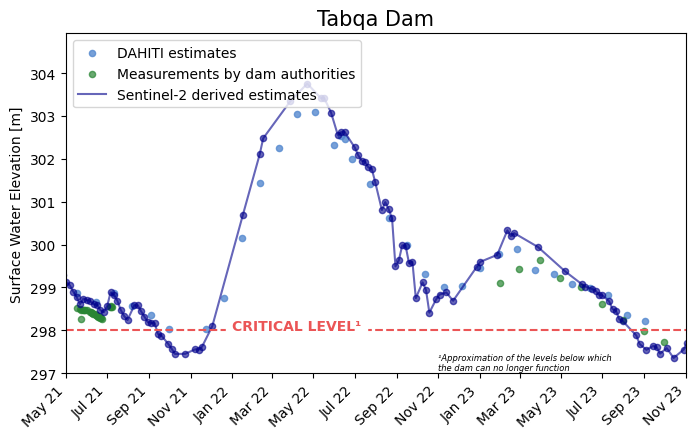

In [80]:
#### Select time frame ####
ts_start = '2021-05-01'
# ts_end = date_today
ts_end = '2023-11-01'
labels = ['DAHITI estimates', 'Sentinel-2 derived estimates', 'Measurements by dam authorities']
mpl.rcdefaults()
mpl.rcParams['figure.figsize'] = (8, 5)
# mpl.rcParams['font.sans-serif'] = 'Arial Narrow'


ax = plt.gca()
df_chart.plot(x ='Date', y='Water level [m] (DAHITI)', color='#5589cf', alpha=0.8, kind = 'scatter',ax=ax,label=labels[0])
df_chart.plot(x ='Date', y='Water level [m] (dam auth.)', color='#298534', alpha=0.7, kind = 'scatter',ax=ax,label=labels[2])
df_water_level_withoutGaps.plot(x ='Date', y='Water level [m] (pred.)', color='darkblue', alpha = 0.6,kind = 'scatter',ax=ax,legend=False)

df_water_level_withoutGaps.plot(x ='Date', y='Water level [m] (pred.)', color='darkblue', alpha = 0.6,kind = 'line',ax=ax,label=labels[1])
ax.legend(loc='upper left')
# ax.legend(bbox_to_anchor=(0.5, 0.77))

plt.axhline(y = dead_level, color = '#EB5556', linestyle = 'dashed')
plt.text(pd.to_datetime(ts_start)+pd.DateOffset(months=8), dead_level, "CRITICAL LEVEL¹", color = '#EB5556',backgroundcolor = 'white',weight='bold')

# place a text box in upper left in axes coords
props = dict(boxstyle='round', facecolor='white', alpha=0, edgecolor = 'white')
# plt.text(0.01, 0.06, '\n'.join(('¹Approximation of the levels below which', 'the dam can no longer function')), transform=ax.transAxes, fontsize=6, verticalalignment='top',style='italic', bbox=props)
ax.text(0.6, 0.06, '\n'.join(('¹Approximation of the levels below which', 'the dam can no longer function')), transform=ax.transAxes, fontsize=6, verticalalignment='top',style='italic', bbox=props)


plt.xticks(rotation=45)
ax.xaxis.set_major_formatter(date_form)
ax.xaxis.label.set_visible(False) # set label 'Date' invisible
ax.xaxis.set_major_locator(mdates.MonthLocator(interval=2)) # adjdust the x-axis labels

ax.set_xlim(pd.to_datetime(ts_start), pd.to_datetime(ts_end))
if AOI_name == 'Tishreen': ax.set_ylim(319.3,326.8)

plt.ylabel("Surface Water Elevation [m]")
plt.title(AOI_name + ' Dam', fontsize=15)

### Download figure
file_name = AOI_name + '_water_level_allSeries_' +ts_start + '-' + last_water_level_date + '.jpg'
file_name
plt.savefig(file_name, dpi=600, bbox_inches='tight')
# files.download(file_name)

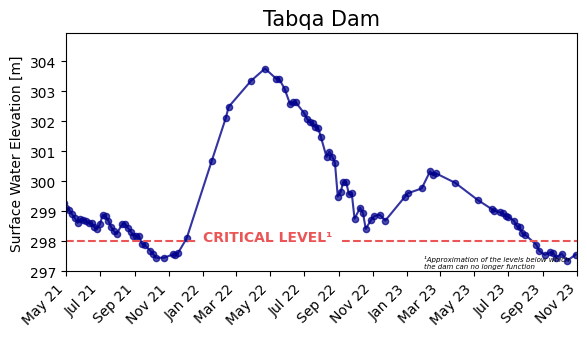

In [ ]:
# #### Select 6 months time frame ####
# ts_start = '2021-05-01'
# # ts_end = date_today
# ts_end = '2023-11-01'

# mpl.rcdefaults()
# mpl.rcParams['figure.figsize'] = (6.6, 3.5)
# # mpl.rcParams['font.sans-serif'] = 'Arial Narrow'

# ax = plt.gca()

# # df_chart.plot(x ='Date', y='Water level [m] (pred.)', color='darkblue', alpha = 0.7,kind = 'scatter',ax=ax)
# df_water_level_withoutGaps.plot(x ='Date', y='Water level [m] (pred.)', color='darkblue', alpha = 0.7,kind = 'scatter',ax=ax,legend=False)
# df_water_level_withoutGaps.plot(x ='Date', y='Water level [m] (pred.)', color='darkblue', alpha = 0.8,kind = 'line',ax=ax,legend=False)

# plt.axhline(y = dead_level, color = '#EB5556', linestyle = 'dashed')
# plt.text(pd.to_datetime(ts_start)+pd.DateOffset(months=8), dead_level, "CRITICAL LEVEL¹", color = '#EB5556',backgroundcolor = 'white',weight='bold')

# props = dict(boxstyle='round', facecolor='white', alpha=0, edgecolor = 'white')

# # place a text box in upper left in axes coords
# ax.text(0.7, 0.07, '\n'.join(('¹Approximation of the levels below which', 'the dam can no longer function')), transform=ax.transAxes, fontsize=5, verticalalignment='top', style='italic', bbox=props)

# plt.xticks(rotation=45)
# ax.xaxis.set_major_formatter(date_form)
# ax.xaxis.label.set_visible(False)
# ax.xaxis.set_major_locator(mdates.MonthLocator(interval=2)) # adjdust the x-axis labels

# ax.set_xlim(pd.to_datetime(ts_start), pd.to_datetime(ts_end))
# if AOI_name == 'Tishreen': ax.set_ylim(319.3,326.8)
# plt.ylabel("Surface Water Elevation [m]")
# plt.title(AOI_name + ' Dam', fontsize=15)

# ### Download figure
# file_name = AOI_name + '_water_level_' + ts_start + '-' + last_water_level_date + '.jpg'
# file_name
# plt.savefig(file_name, dpi=600, bbox_inches='tight')
# # files.download(file_name) # uncomment for downloading
